## Project 1: Regression analysis and resampling methods

#### Noel Gomariz Kühne

**Exercise 1. Ordinary Least Square on the Franke Function**

The aim of this exercise is to apply the Ordinary Least Square method to fit a two-dimensional function, the Franke Function:

\begin{align*}
    f(x, y) &= \frac{3}{4}\exp\left( -\frac{(9x - 2)^2}{4} - \frac{(9y-2)^2}{4} \right) + \frac{3}{4}\exp\left( -\frac{(9x + 1)^2}{49} - \frac{(9y+1)^2}{10} \right) \\
    & + \frac{1}{2}\exp\left( -\frac{(9x - 7)^2}{4} - \frac{(9y-3)^2}{4} \right) - \frac{1}{5}\exp\left( -(9x - 4)^2 - (9y-7)^2 \right)
\end{align*}

We will generate an artificial data set with values of $x$ and $y$ between $[0, 1]$ and add some random noise to better recreate a real scenario

\begin{align*}
    y_i = f_i + N(0, 1)
\end{align*}

and perform a standard linear regression to fit a polynomial in $x$ and $y$ up to fifth order. Once the data set is generated, the only steps taken before the actual regression is the split of the data into train and test, with a test ratio of $20\%$, and the creation of a design matrix containing all the terms of a polynomial of order $q$. No scaling has been made because our data is already contained into a normalised domain, and there is no risk of overflow. 

In [1]:
# Algorithm to create a design matrix for a 2-dimensional polynomial up to order q

def DesignMatrix2Var(x1, x2, q):
    '''q is the order of the polynomial to which we wish to
    fit the data.'''
    
    n = len(x1)
    p = int((q+1)*(q+2)/2)  # number of terms aka columns of the design matrix
    X = []
    
    for i in range(n):
        row = [1.0]   # This algorithm allows to fit the intercept  
        for j in range(1, q+1):
            lim_inf = int(j + (j-1)*j/2)
            lim_sup = int(2*j + 1 + (j-1)*j/2)
            exp = 0
            for k in range(lim_inf, lim_sup):
                row.append(x2[i]**exp * x1[i]**(j-exp))
                exp += 1
        X.append(row)
    
    X = np.array(X)
    
    return X

We also define some relevant functions for all the project:

In [2]:
# Franke function
def FrankeFunc(x, y):
    s1 = 0.75 * np.exp(-0.25*(9*x-2)**2 - 0.25*(9*y-2)**2)
    s2 = 0.75 * np.exp(-(9*x-2)**2/49 - (9*y-2)**2/10)
    s3 = 0.5 * np.exp(-0.25*(9*x-7)**2 - 0.25*(9*y-3)**2)
    s4 = -0.2 * np.exp(-(9*x-4)**2 - (9*y-7)**2)
    
    return s1+s2+s3+s4


# Mean squared error function
def MSE(y_data, y_model):
    return np.mean((y_data-y_model)**2)


# R2 
def R2(y_data, y_model):
    y_mean = np.mean(y_data)
    return 1-np.sum( (y_data - y_model)**2 )/np.sum( (y_data-y_mean)**2 )


def bias(y_test, y_pred):
    return np.mean( (y_test - np.mean(y_pred))**2 )


def variance(y_pred):
    return np.mean( (y_pred - np.mean(y_pred))**2 )


# Function to obtain the estimators of the OLS
def myRegression(X, y):
    return np.linalg.pinv(X.T @ X) @ X.T @ y

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
plt.style.use('seaborn')
np.random.seed(1812)

n = 600
x0, x1 = np.random.rand(n), np.random.rand(n)
y = FrankeFunc(x0, x1) + 0.3*np.random.randn(n)

p_degree = 5

# Build the design matrix and split the data
X = DesignMatrix2Var(x0, x1, p_degree)

X_train, X_test = train_test_split(X, test_size=0.2)
y_train, y_test = train_test_split(y, test_size=0.2)

beta = myRegression(X_train, y_train)
y_tilde = X_train @ beta  # prediction of the train data
y_pred = X_test @ beta  # prediction of the test data

# MSE and R2
print(f'MSE of training data: {MSE(y_train, y_tilde)}')
print(f'MSE of test data: {MSE(y_test, y_pred)}')
print('-'*15)
print(f'R2 of train data: {R2(y_train, y_tilde)}')
print(f'R2 of test data: {R2(y_test, y_pred)}')

MSE of training data: 0.25116280857039397
MSE of test data: 0.27988358742166874
---------------
R2 of train data: 0.027983483916094842
R2 of test data: -0.09747512674677306


Now we proceed to obtain the confidence intervals for the estimators $\beta$ by calculating their variance, which is proportional to the inverse of the covariance matrix.

\begin{align}
    var(\mathbf{\beta}) = \sigma^2 (\mathbf{X^T}\cdot\mathbf{X})^{-1}
\end{align}

where $\sigma$ is the standard deviation of the noise of the data.

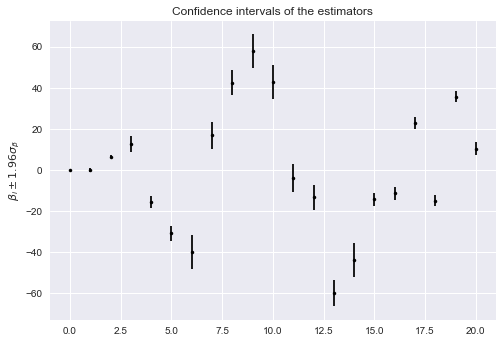

In [4]:
# Confidence intervals of the estimators beta
cov = np.linalg.pinv(X_train.T @ X_train)
var_b = np.array([cov[i, i] for i in range(len(cov))])
sigma_b = np.sqrt(var_b/n)  # standard deviation of the parameters

# Plot the confidence interval between 2 sigmas for each parameter
plt.errorbar(range(21), beta, yerr=1.96*sigma_b, fmt='.k')  
plt.title('Confidence intervals of the estimators')
plt.ylabel(r'$\beta_i \pm 1.96\sigma_{\beta}$')
plt.show()

**Exercise 2: Resampling techniques and bias-variance tradeoff**

In this exercise we will study how the mean squared error (MSE) changes with respect to the model complexity, in our case the degree of the polynomial used to fit the data. We will also perform a bias-variance tradeoff analysis using the bootstrap resampling method on different models. Let's assume that our data is generated by a noisy mode, $y_i = f_i + \epsilon_i$. Thus, the mean squared error can be writen in the so called bias-variance tradeoff form:

\begin{align}
    \mathbb{E}[(y - \tilde{y})^2] &= \mathbb{E}[f + \epsilon - \tilde{y}] \\
&= \frac{1}{n}\sum (f_i - \mathbb{E}[\tilde{y}])^2 + \frac{1}{n}\sum (\tilde{y}_i - \mathbb{E}[\tilde{y}])^2 + \sigma^2
\end{align}

where the first term is called the *bias*, and it expresses how far are the predicted values from the sample mean; the second term, called *variance*, means how spread out are the obtained points; and the last term is the standard deviation of the noise of the model.

Before performing a bias-variance tradeoff analysis, we are goint to study how the MSE fluctuates with respect to the degree of the polynomial used to fit the data. 

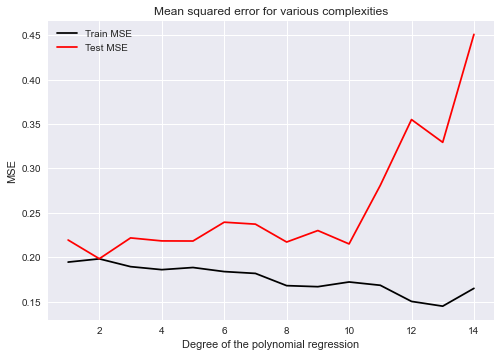

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
plt.style.use('seaborn')
# np.random.seed(7968)

n = 400
x0, x1 = np.random.rand(n), np.random.rand(n)
y = FrankeFunc(x0, x1) + 0.2*np.random.randn(n)

max_deg = 14
comp = []
trainMSE = []
testMSE = []

for p in range(1, max_deg+1):    
    X = DesignMatrix2Var(x0, x1, p)
    X_train, X_test = train_test_split(X, test_size=0.2)
    y_train, y_test = train_test_split(y, test_size=0.2)
    beta = myRegression(X_train, y_train)
    y_tilde = X_train @ beta
    y_pred = X_test @ beta
    
    comp.append(p)
    trainMSE.append(MSE(y_train, y_tilde))
    testMSE.append(MSE(y_test, y_pred))
    

fig, ax = plt.subplots()
ax.set_title('Mean squared error for various complexities')
ax.set_xlabel('Degree of the polynomial regression')
ax.set_ylabel('MSE')

ax.plot(comp, trainMSE, color='black', label='Train MSE')
ax.plot(comp, testMSE, color='red', label='Test MSE')
ax.legend()
plt.show()

In the graph we can see how the training mean squared error decreases when we increase the degree of the polynomial as it is able to go through all the data points, but the test MSE becomes higher and higher. This is the famous phenomenom called *overfitting*.

Now is time to study the bias-variance tradeoff togheter with the bootstrap resampling technique, for which we will use the *Sci-Kit Learn* function *resample*.

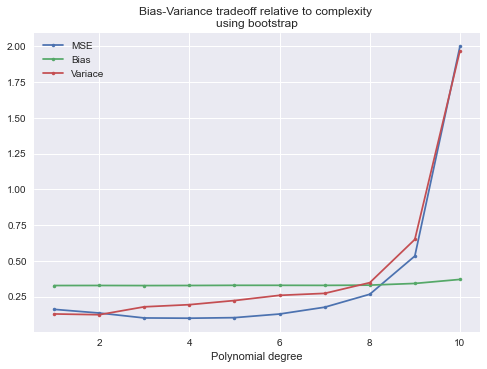

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
plt.style.use('seaborn')
np.random.seed(3121)

# data set
n = 300
max_deg = 10

n_boot = 100  # number of times data is resampled

x0, x1 = np.random.rand(n), np.random.rand(n)
x = np.array([x0, x1]).T
y = FrankeFunc(x0, x1) + 0.3*np.random.randn(n)

# test data is never used during bootstrap
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# these lists will be used to store the mean values of the quantities described
# for a later plot with respect to the complexity
train_error = []
Error = []
Bias = []
Variance = []

for p in range(1, max_deg+1):  # loop for complexity
    model = make_pipeline(PolynomialFeatures(degree=p), LinearRegression(fit_intercept=False))
    
    # initializing the needed arrays to store data
    err = np.zeros(n_boot)
    bi = np.zeros(n_boot)
    var = np.zeros(n_boot)
    
    for k in range(n_boot):  # loop for bootstrap
        x_, y_ = resample(x_train, y_train)
        y_pred = model.fit(x_, y_).predict(x_test)
    
        err[k] = MSE(y_test, y_pred)
        bi[k] = np.mean( (y_test - np.mean(y_pred))**2 )
        var[k] = np.mean( (y_pred - np.mean(y_pred))**2 )
    
    Error.append(np.mean(err))
    Bias.append(np.mean(bi))
    Variance.append(np.mean(var))
    

plt.plot(range(1, max_deg+1), Error, '.-', label='MSE')
plt.plot(range(1, max_deg+1), Bias, '.-', label='Bias')
plt.plot(range(1, max_deg+1), Variance, '.-', label='Variace')

plt.title('Bias-Variance tradeoff relative to complexity \nusing bootstrap')
plt.xlabel('Polynomial degree')
plt.legend()
plt.show()

**Exercise 3: Cross-Validation applied to Ordinary Least Squares**

This exercise will show how the cross-validation resampling technique applies to the ordinary least squares regression. To start with we will perform a bias-variance tradeoff analysis with $k=5$ folds of the data.

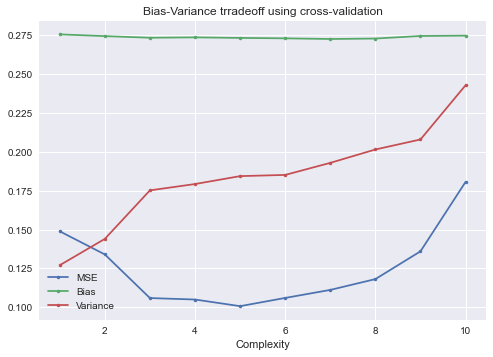

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score
plt.style.use('seaborn')
np.random.seed(3121)

# Dataset
n = 300
x0, x1 = np.random.rand(n), np.random.rand(n)
x = np.array([x0, x1]).T
y = FrankeFunc(x0, x1).reshape(-1, 1) + 0.3*np.random.randn(n).reshape(-1, 1)

k = 5
kfold = KFold(n_splits=k)

Error = []
Bias = []
Variance = []
max_deg = 10

for p in range(1, max_deg+1):
    err = []
    bi = []
    var = []
    model = make_pipeline(PolynomialFeatures(degree=p), LinearRegression(fit_intercept=False))
    
    
    for idx_train, idx_test in kfold.split(x):
        x_train, y_train = x[idx_train], y[idx_train]
        x_test, y_test = x[idx_test], y[idx_test]
        fit = model.fit(x_train, y_train)
        y_pred = fit.predict(x_test)

        err.append(MSE(y_test, y_pred))
        bi.append(np.mean( (y_test - np.mean(y_pred))**2 ))
        var.append(np.mean( (y_pred - np.mean(y_pred))**2 ))
    
    Error.append(np.mean(err))
    Bias.append(np.mean(bi))
    Variance.append(np.mean(var))

plt.plot(range(1, max_deg+1), Error, '.-', label='MSE')
plt.plot(range(1, max_deg+1), Bias, '.-', label='Bias')
plt.plot(range(1, max_deg+1), Variance, '.-', label='Variance')

plt.xlabel('Complexity')
plt.title('Bias-Variance trradeoff using cross-validation')
plt.legend()
plt.show()

From the avobe expression for the MSE we would expect the mean squared error to be greater than the bias and the variance, in fact greater than the sum of them both, but we don't get that result. A possible explanation for that is that when we add noise to the data, we are not generating real random numbers but pseudo-random numbers, which are correlated. Despite that adverse feature, we can see that for the same problem the cross-validation technique results in a better mean squared error for the same complexities, which is due mainly to the fact that cross-validation uses the whole data set for training, while when using bootstrap we resample the same train data for all the iterations. Now we will modify the number of folds used to divide the data and see if it affects the behaviour of the model.

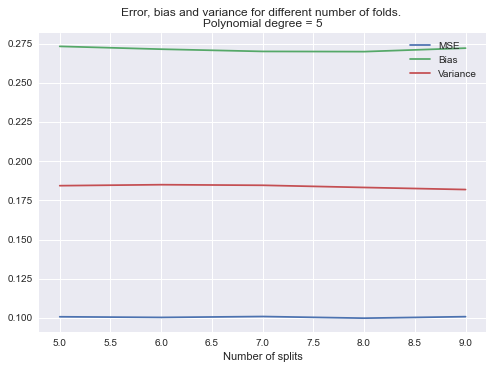

In [9]:
# Apply cross validation to a polynomial fit with degree = 5

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score
plt.style.use('seaborn')
np.random.seed(3121)

# Dataset
n = 300
x0, x1 = np.random.rand(n), np.random.rand(n)
x = np.array([x0, x1]).T
y = FrankeFunc(x0, x1).reshape(-1, 1) + 0.3*np.random.randn(n).reshape(-1, 1)

deg = 5
n_folds = range(5, 10)
model = make_pipeline(PolynomialFeatures(degree=deg), LinearRegression(fit_intercept=False))

Error, Bias, Variance = [], [], []

for k in n_folds:
    err, bi, var = [], [], []
    fold = KFold(n_splits=k)
    for idx_train, idx_test in fold.split(x):
        x_train, y_train = x[idx_train], y[idx_train]
        x_test, y_test = x[idx_test], y[idx_test]
        
        y_pred = model.fit(x_train, y_train).predict(x_test)
        
        err.append(MSE(y_test, y_pred))
        bi.append(np.mean( (y_test - np.mean(y_pred))**2 ))
        var.append(np.mean( (y_pred - np.mean(y_pred))**2 ))
    
    Error.append(np.mean(err))
    Bias.append(np.mean(bi))
    Variance.append(np.mean(var))


plt.plot(n_folds, Error, label='MSE')
plt.plot(n_folds, Bias, label='Bias')
plt.plot(n_folds, Variance, label='Variance')

plt.title('Error, bias and variance for different number of folds. \nPolynomial degree = 5')
plt.xlabel('Number of splits')
plt.legend()
plt.show()

In the figure we see that while the number of slots in which we divide the data is between 5 and 10, these quantities remain almost constant. This behaviour ensures that the performance of the method is not due to the number of folds, but to the fact that we are using all the data for training and test.

**Resampling techniques on Ridge regression**

The Ridge regression is a linear model which adds a regularization parameter to the ordinary least squares by modifying the cost function:

\begin{align}
    c(\mathbf{\beta}) = \|\mathbf{y}-\mathbf{X \beta}\| + \lambda \| \mathbf{\beta} \|^2
\end{align}

This section will explore how the Ridge regression applies to the Franke function for different values of the regularization parameter and different polynomial orders, but first we will study which is the best $\lambda$ for each complexity.

In [3]:
# We start by defining a function that calculates the parameters of the Ridge Regression
def myRidge(X, y, lmb):
    n_samp, n_feat = X.shape
    I = np.eye(n_feat)
    return np.linalg.pinv(X.T @ X + lmb*I) @ X.T @ y

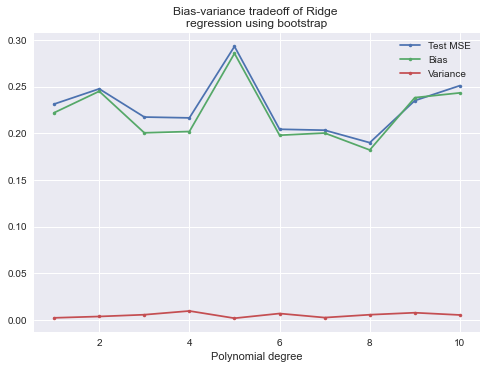

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
plt.style.use('seaborn')
np.random.seed(45641)

n = 300
x0, x1 = np.random.rand(n), np.random.rand(n)
y = FrankeFunc(x0, x1) + 0.1*np.random.randn(n)

n_lam = 200
l_space = np.logspace(-2, 3, n_lam)

max_deg = 10
best_lmd = np.zeros(max_deg)

for p in range(1, max_deg+1):
    X = DesignMatrix2Var(x0, x1, p)
    X_train, X_test = train_test_split(X, test_size=0.2)
    y_train, y_test = train_test_split(y, test_size=0.2)
    
    err = []  # list to store the error for each lambda
    for l in l_space:
        beta = myRidge(X_train, y_train, l)
        y_pred = X_test @ beta
        err.append(MSE(y_test, y_pred))

    k = err.index(min(err))  # we only keep the one that spits out the best mean squared error
    best_lmd[p-1] = l_space[k]
#     print(f'Polynomial degree = {p}')
#     print(f'Best MSE: {min(err)}')
#     print(f'𝜆 that minimizes it: {best_lmd[p-1]}')
#     print('-'*15)
    

# Now the bias-variance tradeoff with bootstrap
n_boot = 100
Error = []
Bias = []
Variance = []

for p in range(1, max_deg+1):
    X = DesignMatrix2Var(x0, x1, p)
    X_train, X_test = train_test_split(X, test_size=0.2)
    y_train, y_test = train_test_split(y, test_size=0.2)
    
    err = np.zeros(n_boot)
    bi = np.zeros(n_boot)
    var = np.zeros(n_boot)
    for j in range(n_boot):
        X_, y_ = resample(X_train, y_train)
        beta = myRidge(X_, y_, best_lmd[p-1])
        y_pred = X_test @ beta
        err[j] = MSE(y_test, y_pred)
        bi[j] = bias(y_test, y_pred)
        var[j] = variance(y_pred)
    
    Error.append(np.mean(err))
    Bias.append(np.mean(bi))
    Variance.append(np.mean(var))

ps = range(1, max_deg+1)
plt.plot(ps, Error, '.-', label='Test MSE')
plt.plot(ps, Bias, '.-', label='Bias')
plt.plot(ps, Variance, '.-', label='Variance')
plt.xlabel('Polynomial degree')
plt.legend()
plt.title('Bias-variance tradeoff of Ridge \nregression using bootstrap')
plt.show()

For each degree analysed we have used the regularization parameter that best fits the data. This time we observe that the relation $MSE > bias + variance$ is satisfied.

Now we are going to study how some polynomial models perform relative to the regularization parameter but using the cross validation method instead.

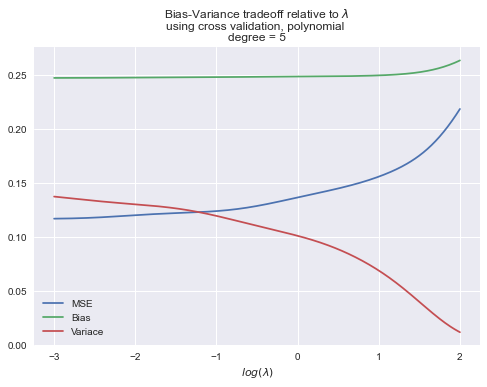

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
plt.style.use('seaborn')
np.random.seed(651785)

n = 400
x0, x1 = np.random.rand(n), np.random.rand(n)
y = FrankeFunc(x0, x1) + 0.3*np.random.randn(n)
degree = 5
X = DesignMatrix2Var(x0, x1, degree)

k = 6
kfold = KFold(n_splits=k)
n_lmd = 300
lambdas = np.logspace(-3, 2, n_lmd)

Error, Bias, Variance, TrainError = [], [], [], []

for lmd in lambdas:
    err = []
    bi = []
    var = []
    tr_err = []
    
    for idx_train, idx_test in kfold.split(X):
        X_train, y_train = X[idx_train], y[idx_train]
        X_test, y_test = X[idx_test], y[idx_test]
        
        beta = myRidge(X_train, y_train, lmd)
        y_pred = X_test @ beta
        y_tilde = X_train @ beta
        
        err.append(MSE(y_pred, y_test))
        bi.append(bias(y_test, y_pred))
        var.append(variance(y_pred))
    
    Error.append(np.mean(err))
    Bias.append(np.mean(bi))
    Variance.append(np.mean(var))
    
range_lmd = np.log10(lambdas)
plt.plot(range_lmd, Error, label='MSE')
plt.plot(range_lmd, Bias, label='Bias')
plt.plot(range_lmd, Variance, label='Variace')

plt.xlabel(r'$log(\lambda)$')
plt.legend()
plt.title(r'Bias-Variance tradeoff relative to $\lambda$'+'\nusing cross validation, polynomial \ndegree = 5')
plt.show()

If we take a closer look at the previous graphs and the values of the mean squared error for the different models, we can conclude that for this model (polynomial of degree 5) the ordinary least squares regression is a better model for the Franke function. For the same polynomial degree, the best value obtained for the MSE is the one with $\lambda \approx 0$, which is equivalent to the OLS. 

**Lasso regression and resampling techniques**

In the following section we will explore how the lasso regression applies to the Franke function, and also the implementation of the resampling techniques we have already looked at. Lasso regression is defined by the cost function

\begin{align}
    c(\mathbf{\beta}) = \|\mathbf{y}-\mathbf{X \beta}\| + \lambda \| \mathbf{\beta} \|
\end{align}

First let us repeat the analysis from the previous exercise and find the best regularization parameter for each complexity by estimating the mean square error. As in the previous exercises, no scaling of the data is made because the sample points are already normalised.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
plt.style.use('seaborn')
np.random.seed(78654)

n = 400
max_deg = 10
x0, x1 = np.random.rand(n), np.random.rand(n)
x = np.array([x0, x1]).T
y = FrankeFunc(x0, x1).reshape(-1, 1) + 0.3*np.random.randn(n).reshape(-1, 1)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

n_lambdas = 200
lams = np.logspace(-2, 2, n_lambdas)

Error = []
best_lmd = []

for p in range(1, max_deg+1):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    err = []

    for l in lams:
        model = make_pipeline(PolynomialFeatures(degree=p), Lasso(alpha=l, fit_intercept=False))
        fit = model.fit(x_train, y_train)
        y_pred = fit.predict(x_test)
        y_tilde = fit.predict(x_train)
        
        err.append(MSE(y_test, y_pred))
    
    best_lmd.append(lams[err.index(min(err))])
    Error.append(min(err))

In [56]:
for i in range(max_deg):
    print(f'Test MSE: {Error[i]}')
    print(f'Best lambda: {best_lmd[i]}')
    print('-'*15)

Test MSE: 0.30409606319282645
Best lambda: 0.06669919663030122
---------------
Test MSE: 0.30641053624862435
Best lambda: 0.08026433522257174
---------------
Test MSE: 0.30641053624862435
Best lambda: 0.08026433522257174
---------------
Test MSE: 0.30641053624862435
Best lambda: 0.08026433522257174
---------------
Test MSE: 0.30641053624862435
Best lambda: 0.08026433522257174
---------------
Test MSE: 0.30641053624862435
Best lambda: 0.08026433522257174
---------------
Test MSE: 0.30641053624862435
Best lambda: 0.08026433522257174
---------------
Test MSE: 0.30641053624862435
Best lambda: 0.08026433522257174
---------------
Test MSE: 0.30641053624862435
Best lambda: 0.08026433522257174
---------------
Test MSE: 0.30641053624862435
Best lambda: 0.08026433522257174
---------------


In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
plt.style.use('seaborn')
np.random.seed(78654)

n = 400
max_deg = 10
x0, x1 = np.random.rand(n), np.random.rand(n)
x = np.array([x0, x1]).T
y = FrankeFunc(x0, x1).reshape(-1, 1) + 0.3*np.random.randn(n).reshape(-1, 1)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

n_lambdas = 200
lams = np.logspace(-2, 2, n_lambdas)

n_boot = 200

Error, Bias, Variance = np.zeros(max_deg), np.zeros(max_deg), np.zeros(max_deg)

for p in range(1, max_deg+1):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    l = best_lmd[p-1]
    model = make_pipeline(PolynomialFeatures(degree=p), Lasso(alpha=l, fit_intercept=False))
    err, bi, var = np.zeros(n_boot), np.zeros(n_boot), np.zeros(n_boot)
    
    for loop in range(n_boot):
        x_boot, y_boot = resample(x_train, y_train)
        fit = model.fit(x_boot, y_boot)
        y_pred = fit.predict(x_test)
        err[loop] = MSE(y_test, y_pred)
        bi[loop] = bias(y_test, y_pred)
        var[loop] = variance(y_pred)
    
    Error[p-1] = np.mean(err)
    Bias[p-1] = np.mean(bi)
    Variance[p-1] = np.mean(var)

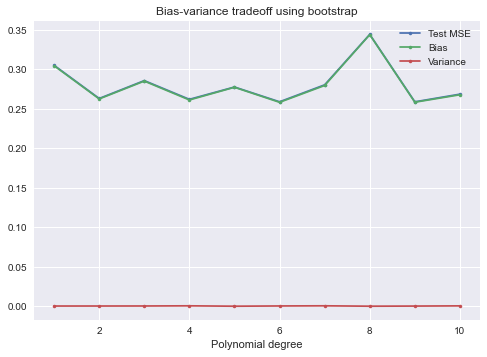

In [62]:
ps = range(1, max_deg+1)
plt.plot(ps, Error, '.-', label='Test MSE')
plt.plot(ps, Bias, '.-', label='Bias')
plt.plot(ps, Variance, '.-', label='Variance')
plt.xlabel('Polynomial degree')
plt.legend()
plt.title('Bias-variance tradeoff using bootstrap')
plt.show()

The conclusion we get from the bias-variance tradeoff analysis of the 3 regressions is that for lower complexities, the ordinary least squares regression performs better than the lasso and ridge regressions, even for the best regularization parameters. Nevertheless, when the complexity of the model grows, the implementation of the regularization parameter gives a better result for the mean squared error and the variance.

Now let's represent how the mean squared error changes with respect to the $\lambda$ parameter for the polynomial model of degree 5.

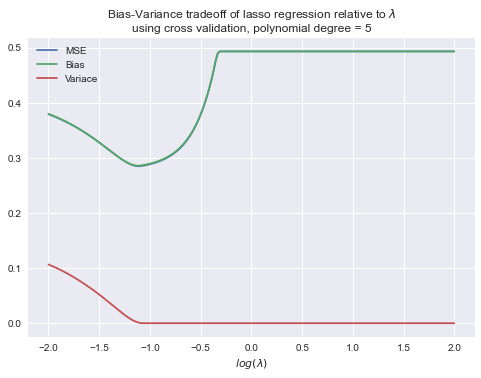

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
plt.style.use('seaborn')

n = 400
p = 5
x0, x1 = np.random.rand(n), np.random.rand(n)
x = np.array([x0, x1]).T
y = FrankeFunc(x0, x1).reshape(-1, 1) + 0.3*np.random.randn(n).reshape(-1, 1)

n_lambdas = 200
lams = np.logspace(-2, 2, n_lambdas)

k = 5
cv = KFold(n_splits=k)

Error, Bias, Variance = np.zeros(n_lambdas), np.zeros(n_lambdas), np.zeros(n_lambdas)

for i in range(n_lambdas):
    l = lams[i]
    err, bi, var = [], [], []
    model = make_pipeline(PolynomialFeatures(degree=p), Lasso(alpha=l, fit_intercept=False))
    
    for id_train, id_test in cv.split(x):
        x_train, y_train = x[id_train], y[id_train]
        x_test, y_test = x[id_test], y[id_test]
        
        fit = model.fit(x_train, y_train)
        y_tilde = fit.predict(x_train)
        y_pred = fit.predict(x_test)
        
        err.append(MSE(y_test, y_pred))
        bi.append(bias(y_test, y_pred))
        var.append(variance(y_pred))
    
    Error[i] = np.mean(err)
    Bias[i] = np.mean(bi)
    Variance[i] = np.mean(var)
    

range_lmd = np.log10(lams)
plt.plot(range_lmd, Error_train, label='MSE')
plt.plot(range_lmd, Error_test, label='Bias')
plt.plot(range_lmd, Variance, label='Variace')

plt.xlabel(r'$log(\lambda)$')
plt.legend()
plt.title(r'Bias-Variance tradeoff of lasso regression relative to $\lambda$'+
          '\nusing cross validation, polynomial degree = 5')
plt.show()

**Terrain data**

In this section we will analyse real data corresponding to the elevation of various places in Norway. The positions will be reproduced manually, already between 0 and 1 so that there is no need to scale them. Nevertheless, the altitude data will be scaled to avoid the loss of numerical precision.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.model_selection import KFold, train_test_split
plt.style.use('seaborn')

In [43]:
np.random.seed(9587533)

z = imread('SRTM_data_Norway_1.tif')
y = z.ravel().reshape(-1, 1)  # rearrange into a column vector 
nx0, nx1 = z.shape

x0, x1 = np.linspace(0, 1, nx0).reshape(-1, 1), np.linspace(0, 1, nx1).reshape(-1, 1)

# Scale the data:
scaler = StandardScaler()
scaler.fit(y)
y_scaled = scaler.fit_transform(y)

# Meshgrid of x and y coordinates
X0, X1 = np.meshgrid(x0, x1)

# Coordinates rearranged into a n_samples array
coordinates = np.vstack([X0.ravel(), X1.ravel()]).T


# Number of data points that will be used for the linear regression
n_points = 2000
x_fit, y_fit = resample(coordinates, y_scaled, n_samples=n_points)

In [8]:
# Now repeat the same analysis as for the made up data
# Study of train and test errors

max_deg = 19

Error_train, Error_test = np.zeros(max_deg), np.zeros(max_deg)
x_train, x_test, y_train, y_test = train_test_split(x_fit, y_fit, test_size=0.2)

for p in range(1, max_deg+1):
    model = make_pipeline(PolynomialFeatures(degree=p), LinearRegression(fit_intercept=False))
    fit = model.fit(x_train, y_train)
    y_tilde = fit.predict(x_train)
    y_pred = fit.predict(x_test)
    
    Error_train[p-1] = np.mean(MSE(y_train, y_tilde))
    Error_test[p-1] = np.mean(MSE(y_test, y_pred))

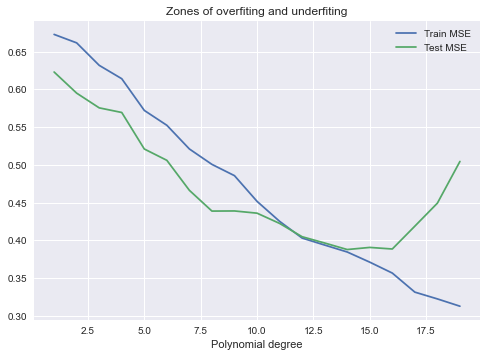

In [9]:
plt.plot(range(1, max_deg+1), Error_train, label='Train MSE')
plt.plot(range(1, max_deg+1), Error_test, label='Test MSE')

plt.title('Zones of overfiting and underfiting')
plt.xlabel('Polynomial degree')
plt.legend()
plt.show()

In [44]:
# Bias-variance tradeoff for OLS applying bootstrap

max_deg = 19
n_boot = 200
x_train, x_test, y_train, y_test = train_test_split(x_fit, y_fit, test_size=0.2)

Error, Bias, Variance = np.zeros(max_deg), np.zeros(max_deg), np.zeros(max_deg)

for p in range(1, max_deg+1):
    model = make_pipeline(PolynomialFeatures(degree=p), LinearRegression(fit_intercept=False))
    
    err, bi, var = np.zeros(n_boot), np.zeros(n_boot), np.zeros(n_boot)
    for i in range(n_boot):
        x_boot, y_boot = resample(x_train, y_train)
        fit = model.fit(x_boot, y_boot)
        y_pred = fit.predict(x_test)
        
        err[i] = MSE(y_test, y_pred)
        bi[i] = bias(y_test, y_pred)
        var[i] = variance(y_pred)
        
    Error[p-1] = np.mean(err)
    Bias[p-1] = np.mean(bi)
    Variance[p-1] = np.mean(var)

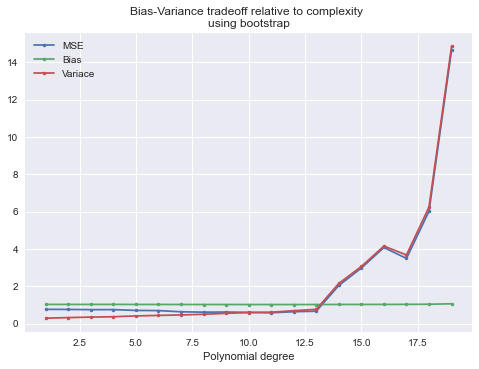

In [45]:
plt.plot(range(1, max_deg+1), Error, '.-', label='MSE')
plt.plot(range(1, max_deg+1), Bias, '.-', label='Bias')
plt.plot(range(1, max_deg+1), Variance, '.-', label='Variace')

plt.title('Bias-Variance tradeoff relative to complexity \nusing bootstrap')
plt.xlabel('Polynomial degree')
plt.legend()
plt.show()

In [48]:
# Now using cross validation instead

n_folds = 5
cv = KFold(n_splits=n_folds)

Error = np.zeros(max_deg)

for p in range(1, max_deg+1):
    model = make_pipeline(PolynomialFeatures(degree=p), LinearRegression(fit_intercept=False))
    err, bi, var = [], [], []
    
    for id_train, id_test in cv.split(x_fit):
        x_train, y_train = x_fit[id_train], y_fit[id_train]
        x_test, y_test = x_fit[id_test], y_fit[id_test]
        
        fit = model.fit(x_train, y_train)
        y_pred = fit.predict(x_test)
        
        err.append(MSE(y_test, y_pred))
        bi.append(bias(y_test, y_pred))
        var.append(variance(y_pred))
    
    Error[p-1] = np.mean(err)
    Bias[p-1] = np.mean(bi)
    Variance[p-1] = np.mean(var)

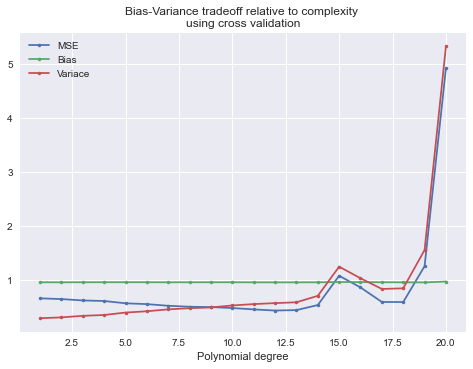

In [49]:
plt.plot(range(1, max_deg+1), Error, '.-', label='MSE')
plt.plot(range(1, max_deg+1), Bias, '.-', label='Bias')
plt.plot(range(1, max_deg+1), Variance, '.-', label='Variace')

plt.title('Bias-Variance tradeoff relative to complexity \nusing cross validation')
plt.xlabel('Polynomial degree')
plt.legend()
plt.show()

Both bootstrap and cross validation return a similar shape for the bias-variance tradeoff figure, but the cross validation method estimates a better mean squared error, as it trains and tests the whole data set.

Now, for the Ridge regression, we are going to reduce the number of data points used for the analysis, so that it doesn't take too many calculations to reproduce the results. First we are going to find out the best $\lambda$ parameter for each model:

In [50]:
np.random.seed(78965)
n_points = 500
x_fit, y_fit = resample(coordinates, y_scaled, n_samples=n_points)
x_train, x_test, y_train, y_test = train_test_split(x_fit, y_fit, test_size=0.2)

max_deg = 20

n_lambdas = 300
lams = np.logspace(-2, 2, n_lambdas)
best_lmd = np.zeros(max_deg)

for p in range(1, max_deg+1):
    err = np.zeros(n_lambdas)
    for i in range(n_lambdas):
        model = make_pipeline(PolynomialFeatures(degree=p), Ridge(alpha=lams[i], fit_intercept=False))
        y_pred = model.fit(x_train, y_train).predict(x_test)
    
        err[i] = MSE(y_test, y_pred)
    
    k = np.where(err == err.min())[0]
    best_lmd[p-1] = lams[k]
    
    print(f'Polynomial degree: {p}')
    print(f'Best mean squared error: {err.min()}')
    print(f'Best lambda: {best_lmd[p-1]}')
    print('-'*15)


Polynomial degree: 1
Best mean squared error: 0.6450314864203293
Best lambda: 0.01
---------------
Polynomial degree: 2
Best mean squared error: 0.6194875909142519
Best lambda: 0.01
---------------
Polynomial degree: 3
Best mean squared error: 0.6029533468864368
Best lambda: 0.06963207939763882
---------------
Polynomial degree: 4
Best mean squared error: 0.601554793241921
Best lambda: 0.1289341296525715
---------------
Polynomial degree: 5
Best mean squared error: 0.5992062762109461
Best lambda: 0.10717668854455029
---------------
Polynomial degree: 6
Best mean squared error: 0.596063990323775
Best lambda: 0.11755310738783693
---------------
Polynomial degree: 7
Best mean squared error: 0.5933503492862218
Best lambda: 0.15040335536380245
---------------
Polynomial degree: 8
Best mean squared error: 0.5911318697938494
Best lambda: 0.192433614111598
---------------
Polynomial degree: 9
Best mean squared error: 0.5892974573363231
Best lambda: 0.23149866718511608
---------------
Polynomia

We can appreciate that, as the complexity of the model grows, so does the $\lambda$ that minimizes the MSE for that model. This indicates that the parameters $\beta$ of the regression get bigger and they are shrunk by $\lambda$. Now that we have obtained the optimal regularization parameters, let's analyse the bias-variance tradeoff in terms of the polynomial degree of the model.

In [51]:
np.random.seed(78965)  # same seed to make sure we use the same parameters as before

n_boot = 100
Error, Bias, Variance = np.zeros(max_deg), np.zeros(max_deg), np.zeros(max_deg)

for p in range(1, max_deg+1):
    err, bi, var = np.zeros(n_boot), np.zeros(n_boot), np.zeros(n_boot)
    model = make_pipeline(PolynomialFeatures(degree=p), Ridge(alpha=best_lmd[p-1], fit_intercept=False))
    for i in range(n_boot):
        x_boot, y_boot = resample(x_train, y_train)
        y_pred = model.fit(x_boot, y_boot).predict(x_test)
        
        err[i] = MSE(y_test, y_pred)
        bi[i] = bias(y_test, y_pred)
        var[i] = variance(y_pred)
        
    Error[p-1] = np.mean(err)
    Bias[p-1] = np.mean(bi)
    Variance[p-1] = np.mean(var)

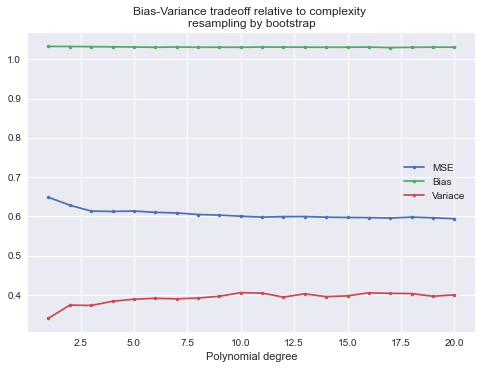

In [52]:
plt.plot(range(1, max_deg+1), Error, '.-', label='MSE')
plt.plot(range(1, max_deg+1), Bias, '.-', label='Bias')
plt.plot(range(1, max_deg+1), Variance, '.-', label='Variace')

plt.title('Bias-Variance tradeoff relative to complexity \nresampling by bootstrap')
plt.xlabel('Polynomial degree')
plt.legend()
plt.show()

In a data set of real data, the ridge regression applied with the optimal $\lambda$ reduces the mean square error and the variance for the models of higher complexities, but we observe that that it does not comes with an increased bias, so we can conclude that this model performs better than the ordinary least squares method.

Once we have implemented the bootstrap method, let's repeat the corresponding calculations but using cross validation as resampling technique. We will use the same data set as for the previous exercise.

In [69]:
n_folds = 5
cv = KFold(n_splits=n_folds)

n_lambdas = 300
lams = np.logspace(-2, 2, n_lambdas)
Error = np.zeros(n_lambdas)

for i in range(n_lambdas):
    model = make_pipeline(PolynomialFeatures(degree=11), Ridge(alpha=lams[i], fit_intercept=False))
    err = []
    for id_train, id_test in cv.split(x_fit):
        x_train, y_train = x_fit[id_train], y_fit[id_train]
        x_test, y_test = x_fit[id_test], y_fit[id_test]
        y_pred = model.fit(x_train, y_train).predict(x_test)
        err.append(MSE(y_test, y_pred))
        
    Error[i] = np.mean(err)

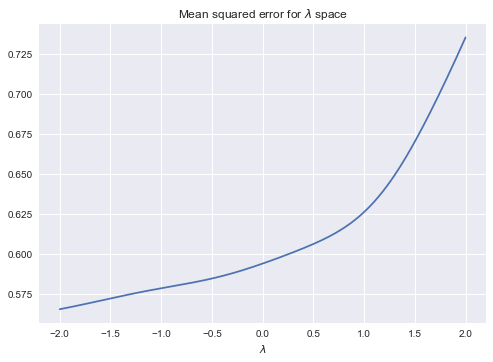

In [70]:
plt.plot(np.log10(lams), Error)

plt.title(r'Mean squared error for $\lambda$ space')
plt.xlabel(r'$\lambda$')
plt.show()

We observe the same result as before: the model is trained with the entire data set and therefore the estimated mean squared error is lower than when we use bootstrap.

The last section of this project will cover the analysis of the terrain data using the lasso regression. Again, we will study which is the best regularization parameter for each model and then analyse the bias-variance tradeoff with the corresponding models. Again, we will reduce the size of the data set to $\approx 500$ data points to be able to run the calculations in a reasonable time.

In [72]:
np.random.seed(87646)
n_points = 500
x_fit, y_fit = resample(coordinates, y_scaled, n_samples=n_points)

In [79]:
max_deg = 20

n_lambdas = 300
lams = np.logspace(-2, 2, n_lambdas)
best_lmd = np.zeros(max_deg)

for p in range(1, max_deg+1):
    x_train, x_test, y_train, y_test = train_test_split(x_fit, y_fit, test_size=0.2)
    err = np.zeros(n_lambdas)
    for i in range(n_lambdas):
        model = make_pipeline(PolynomialFeatures(degree=p), Lasso(alpha=lams[i], fit_intercept=False))
        y_pred = model.fit(x_train, y_train).predict(x_test)
    
        err[i] = MSE(y_test, y_pred)
    
    k = np.where(err == err.min())[0][0]
    best_lmd[p-1] = lams[k]
    
    print(f'Polynomial degree: {p}')
    print(f'Best mean squared error: {err.min()}')
    print(f'Best lambda: {best_lmd[p-1]}')
    print('-'*15)

Polynomial degree: 1
Best mean squared error: 1.1092097997863541
Best lambda: 0.19845354578058033
---------------
Polynomial degree: 2
Best mean squared error: 1.063475878157317
Best lambda: 0.15510844769528398
---------------
Polynomial degree: 3
Best mean squared error: 1.0102147605780312
Best lambda: 0.19845354578058033
---------------
Polynomial degree: 4
Best mean squared error: 1.0105838155061535
Best lambda: 0.15510844769528398
---------------
Polynomial degree: 5
Best mean squared error: 1.116130033523541
Best lambda: 0.19845354578058033
---------------
Polynomial degree: 6
Best mean squared error: 0.8382049430402964
Best lambda: 0.16496480740980207
---------------
Polynomial degree: 7
Best mean squared error: 0.9640751871635533
Best lambda: 0.15040335536380245
---------------
Polynomial degree: 8
Best mean squared error: 1.0375106070669093
Best lambda: 0.21106426791015548
---------------
Polynomial degree: 9
Best mean squared error: 1.236300950174334
Best lambda: 0.16496480740

Here the behaviour of the parameter $\lambda$ is not so obvious, it is not a monotonic function of the complexity of the model but it oscillates around the value $\approx 0.15$.

In [81]:
np.random.seed(87646)  # same seed to make sure we use the same parameters as before

n_boot = 100
Error, Bias, Variance = np.zeros(max_deg), np.zeros(max_deg), np.zeros(max_deg)

for p in range(1, max_deg+1):
    err, bi, var = np.zeros(n_boot), np.zeros(n_boot), np.zeros(n_boot)
    model = make_pipeline(PolynomialFeatures(degree=p), Lasso(alpha=best_lmd[p-1], fit_intercept=False))
    for i in range(n_boot):
        x_boot, y_boot = resample(x_train, y_train)
        y_pred = model.fit(x_boot, y_boot).predict(x_test)
        
        err[i] = MSE(y_test, y_pred)
        bi[i] = bias(y_test, y_pred)
        var[i] = variance(y_pred)
        
    Error[p-1] = np.mean(err)
    Bias[p-1] = np.mean(bi)
    Variance[p-1] = np.mean(var)

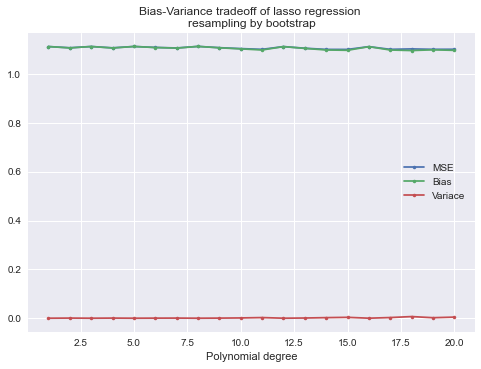

In [82]:
plt.plot(range(1, max_deg+1), Error, '.-', label='MSE')
plt.plot(range(1, max_deg+1), Bias, '.-', label='Bias')
plt.plot(range(1, max_deg+1), Variance, '.-', label='Variace')

plt.title('Bias-Variance tradeoff of lasso regression \nresampling by bootstrap')
plt.xlabel('Polynomial degree')
plt.legend()
plt.show()

Lastly, here is an analysis of the test mean squared error with respect to the regularization parameter for the lasso regression. We will use a polynomial model of degree 8.

In [84]:
n_folds = 5
cv = KFold(n_splits=n_folds)

n_lambdas = 300
lams = np.logspace(-2, 2, n_lambdas)
Error = np.zeros(n_lambdas)

for i in range(n_lambdas):
    model = make_pipeline(PolynomialFeatures(degree=11), Lasso(alpha=lams[i], fit_intercept=False))
    err = []
    for id_train, id_test in cv.split(x_fit):
        x_train, y_train = x_fit[id_train], y_fit[id_train]
        x_test, y_test = x_fit[id_test], y_fit[id_test]
        y_pred = model.fit(x_train, y_train).predict(x_test)
        err.append(MSE(y_test, y_pred))
        
    Error[i] = np.mean(err)

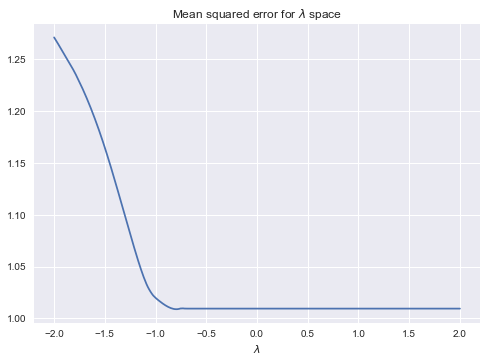

In [85]:
plt.plot(np.log10(lams), Error)

plt.title(r'Mean squared error for $\lambda$ space')
plt.xlabel(r'$\lambda$')
plt.show()

**Last digression: performance of the three regressions.**

Based on the results we have obtained for the mean squared error of the test data for the three different kind of linear regressions, we can conclude that ordinary least squares and ridge regressions are good models to fit the terrain data to low degree polynomials. Nevertheless, there comes a point where the standard ordinary least squares does not perform as well as the ridge and lasso regressions, and the regularization parameter plays a crucial role in fitting the data.